In [32]:
import pandas as pd
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np


# Cargar los datos
with open('filtered_dataset.json', 'r') as f:
    data = json.load(f)

# Convertir a DataFrame
df = pd.DataFrame(data)

In [33]:
shape_original = df.shape
df.columns

Index(['date', 'sender_id', 'establishment_id', 'receptor_id', 'type',
       'currency', 'total', 'items'],
      dtype='object')

# Análisis de la variable TIPO

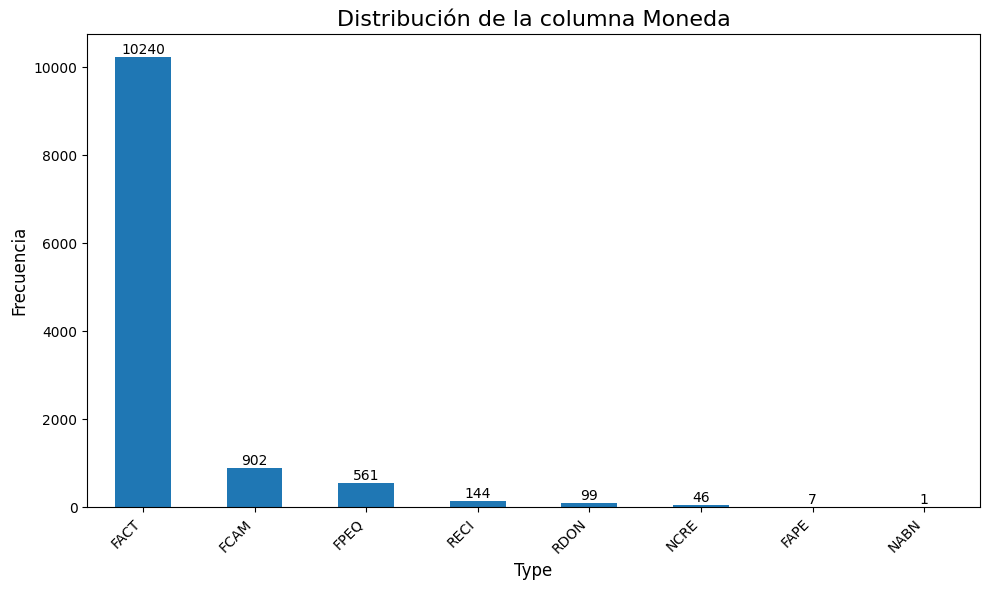

In [34]:
# Calcular la frecuencia de los valores en la columna 'type'
type_counts = df['type'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar')

# Personalizar el gráfico
plt.xlabel('Type', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de la columna Moneda', fontsize=16)
plt.xticks(rotation=45, ha='right')

# Añadir etiquetas de valor encima de cada barra
for i, v in enumerate(type_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

# Análisis de la variable Moneda

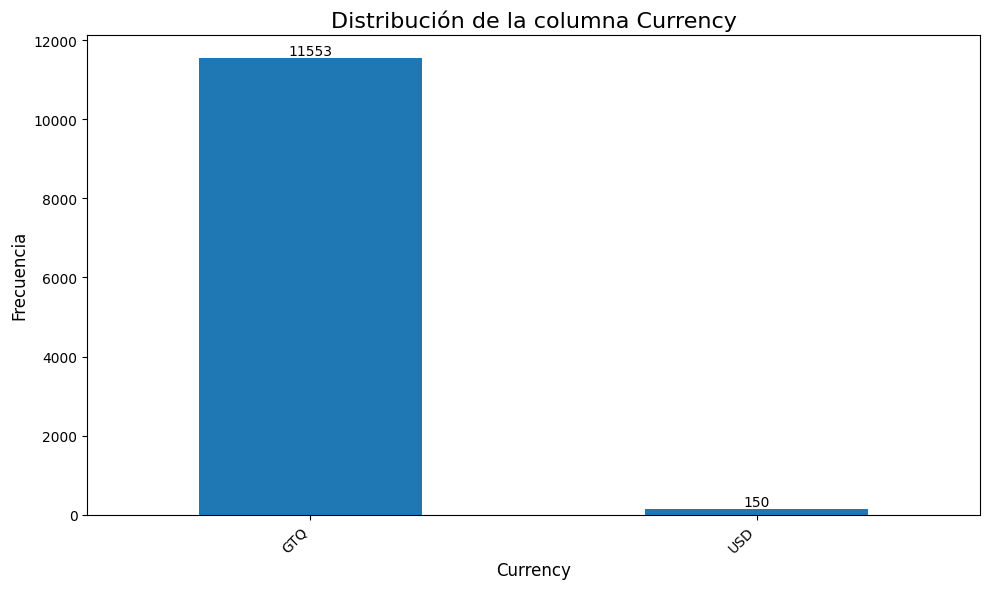

In [35]:
# Filtrar para solo FACTURAS
df = df[df['type'].isin(['FACT', 'FCAM', 'FPEQ'])]

# Calcular la frecuencia de los valores en la columna 'type'
type_counts = df['currency'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar')

# Personalizar el gráfico
plt.xlabel('Currency', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de la columna Currency', fontsize=16)
plt.xticks(rotation=45, ha='right')

# Añadir etiquetas de valor encima de cada barra
for i, v in enumerate(type_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

In [36]:
#Filtrar para solo FACTURAS
df = df[(df['currency'] == 'GTQ')]

# Análisis Temporal

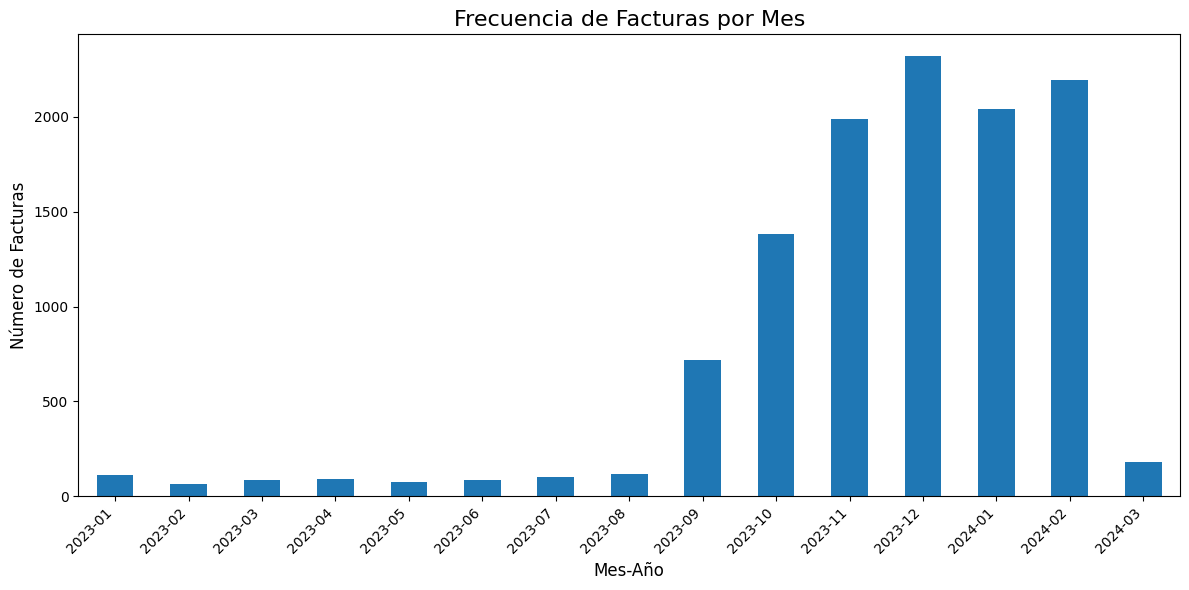

In [37]:
# Convertir la columna 'date' a formato datetime, asegurando que sea datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
# Función para convertir cada valor a solo fecha (sin hora, sin zona horaria)
def convert_to_date(value):
    if pd.isnull(value):
        return None
    if isinstance(value, pd.Timestamp):
        # Convertir a solo fecha
        return value.date()
    else:
        # Intentar convertirlo a datetime y luego a solo fecha
        return pd.to_datetime(value, errors='coerce').date()

# Aplicar la función a cada valor en la columna 'date'
df['date'] = df['date'].apply(convert_to_date)

# Asegurarnos de que el formato de fecha es uniforme
# Extraer el mes y el año de la columna 'date'
df['year_month'] = df['date'].apply(lambda x: x.strftime('%Y-%m') if pd.notnull(x) else None)

# Contar la cantidad de facturas por mes
month_counts = df['year_month'].value_counts().sort_index()

# Graficar el histograma
plt.figure(figsize=(12, 6))
month_counts.plot(kind='bar')

# Personalizar el gráfico
plt.xlabel('Mes-Año', fontsize=12)
plt.ylabel('Número de Facturas', fontsize=12)
plt.title('Frecuencia de Facturas por Mes', fontsize=16)
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.tight_layout()
plt.show()



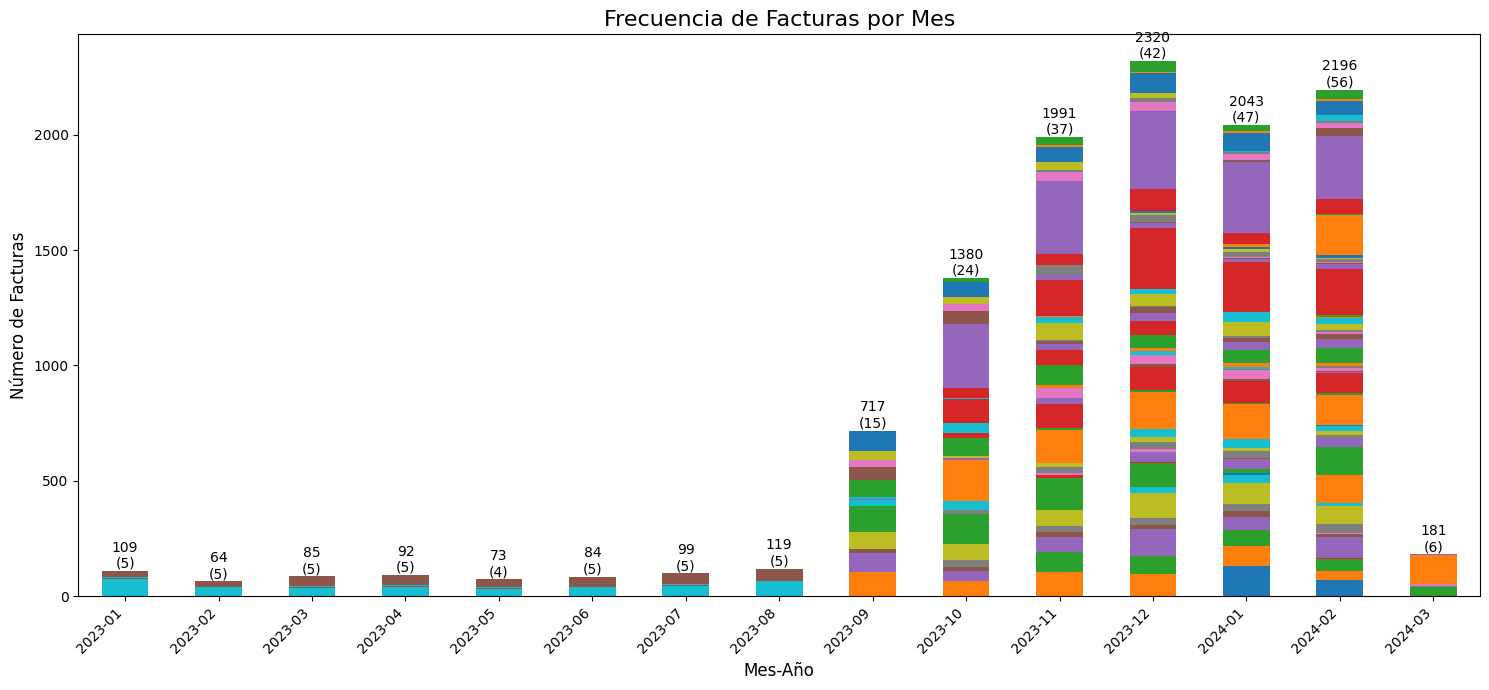

In [38]:
# Crear una nueva columna con el mes y año
df['year_month'] = df['date'].apply(lambda x: x.strftime('%Y-%m') if pd.notnull(x) else None)

# Agrupar por año-mes y sender_id, y contar el número de facturas
grouped = df.groupby(['year_month', 'receptor_id']).size().unstack(fill_value=0)

# Graficar el histograma apilado por mes sin leyenda
ax = grouped.plot(kind='bar', stacked=True, figsize=(15, 7), legend=False)

# Agregar etiquetas sobre cada barra
for i in range(len(grouped)):
    total_facturas = grouped.iloc[i].sum()
    unique_senders = (grouped.iloc[i] > 0).sum()
    ax.text(i, total_facturas + 0.5, f'{total_facturas}\n({unique_senders})', ha='center', va='bottom')

# Personalizar el gráfico
plt.xlabel('Mes-Año', fontsize=12)
plt.ylabel('Número de Facturas', fontsize=12)
plt.title('Frecuencia de Facturas por Mes', fontsize=16)
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [39]:
shape_final = df.shape

print(f"Por el momento el Dataset se ha reducido en un {(1-(shape_final[0]/shape_original[0]))*100}%")

Por el momento el Dataset se ha reducido en un 3.7250000000000005%


# Análisis de Emisor

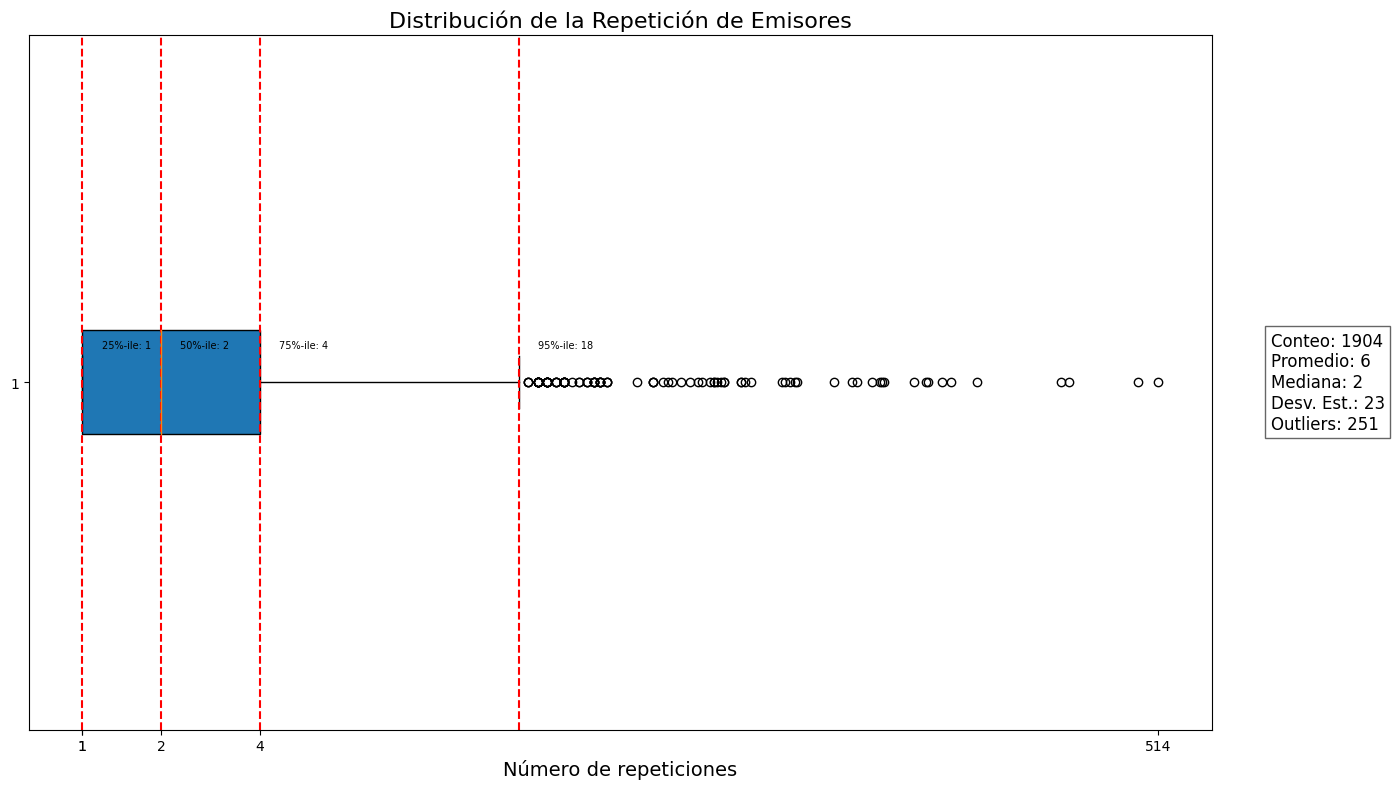

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calcular la frecuencia de los valores en la columna 'receptor_id'
type_counts = df['sender_id'].value_counts()

# Aplicar la transformación logarítmica
log_type_counts = np.log1p(type_counts)

# Crear la gráfica de caja y bigote (boxplot) en escala logarítmica pero mantener el eje X original
plt.figure(figsize=(14, 8))
plt.boxplot(log_type_counts, vert=False, patch_artist=True)

# Calcular estadísticas descriptivas en la escala logarítmica
stats = type_counts.describe()

# Calcular percentiles en la escala original
percentiles = type_counts.quantile([0.25, 0.5, 0.75, 0.95])

# Resaltar percentiles en la gráfica y ajustar las anotaciones para evitar superposición
for percentile, value in percentiles.items():
    plt.axvline(np.log1p(value), color='r', linestyle='--')
    plt.text(np.log1p(value) + 0.1, 1.05, f'{int(percentile*100)}%-ile: {int(value)}', 
             ha='left', va='baseline', fontsize=7, color='black')

# Añadir texto con las estadísticas descriptivas en español
plt.text(1.05, 0.5, f'Conteo: {int(stats["count"])}\n'
                    f'Promedio: {int(stats["mean"])}\n'
                    f'Mediana: {int(stats["50%"])}\n'
                    f'Desv. Est.: {int(stats["std"])}\n'
                    f'Outliers: {int(type_counts[(type_counts < percentiles[0.25] - 1.5 * (percentiles[0.75] - percentiles[0.25])) | (type_counts > percentiles[0.75] + 1.5 * (percentiles[0.75] - percentiles[0.25]))].count())}', 
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(facecolor='white', alpha=0.6), va='center')

# Personalizar el gráfico
plt.xlabel('Número de repeticiones', fontsize=14)
plt.title('Distribución de la Repetición de Emisores', fontsize=16)
plt.xticks(np.log1p(type_counts.quantile([0, 0.25, 0.5, 0.75, 1])), 
           labels=[f'{int(value)}' for value in type_counts.quantile([0, 0.25, 0.5, 0.75, 1])])
plt.tight_layout()
plt.show()


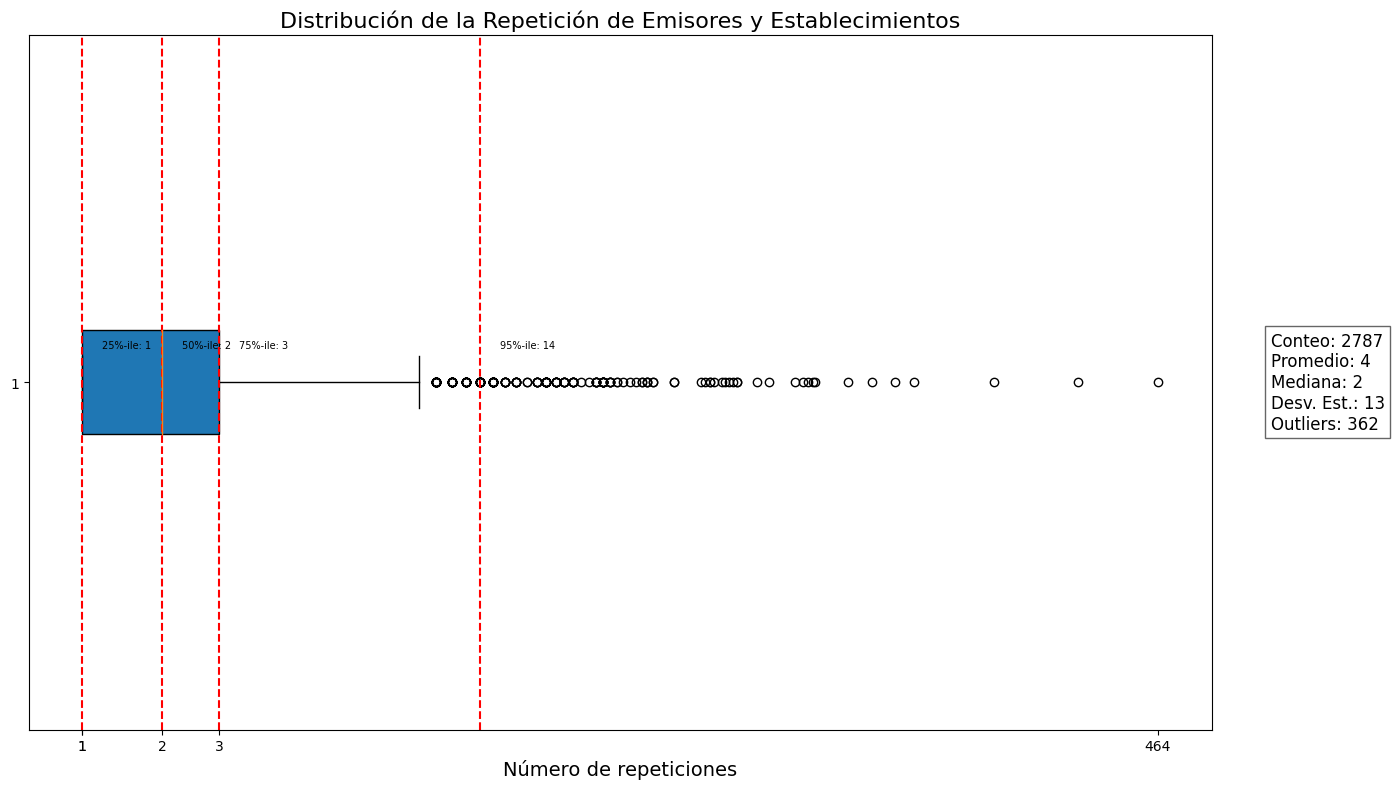

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df["sender_establishment"] = df["sender_id"] + df["establishment_id"]

# Calcular la frecuencia de los valores en la columna 'receptor_id'
type_counts = df['sender_establishment'].value_counts()

# Aplicar la transformación logarítmica
log_type_counts = np.log1p(type_counts)

# Crear la gráfica de caja y bigote (boxplot) en escala logarítmica pero mantener el eje X original
plt.figure(figsize=(14, 8))
plt.boxplot(log_type_counts, vert=False, patch_artist=True)

# Calcular estadísticas descriptivas en la escala logarítmica
stats = type_counts.describe()

# Calcular percentiles en la escala original
percentiles = type_counts.quantile([0.25, 0.5, 0.75, 0.95])

# Resaltar percentiles en la gráfica y ajustar las anotaciones para evitar superposición
for percentile, value in percentiles.items():
    plt.axvline(np.log1p(value), color='r', linestyle='--')
    plt.text(np.log1p(value) + 0.1, 1.05, f'{int(percentile*100)}%-ile: {int(value)}', 
             ha='left', va='baseline', fontsize=7, color='black')

# Añadir texto con las estadísticas descriptivas en español
plt.text(1.05, 0.5, f'Conteo: {int(stats["count"])}\n'
                    f'Promedio: {int(stats["mean"])}\n'
                    f'Mediana: {int(stats["50%"])}\n'
                    f'Desv. Est.: {int(stats["std"])}\n'
                    f'Outliers: {int(type_counts[(type_counts < percentiles[0.25] - 1.5 * (percentiles[0.75] - percentiles[0.25])) | (type_counts > percentiles[0.75] + 1.5 * (percentiles[0.75] - percentiles[0.25]))].count())}', 
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(facecolor='white', alpha=0.6), va='center')

# Personalizar el gráfico
plt.xlabel('Número de repeticiones', fontsize=14)
plt.title('Distribución de la Repetición de Emisores y Establecimientos', fontsize=16)
plt.xticks(np.log1p(type_counts.quantile([0, 0.25, 0.5, 0.75, 1])), 
           labels=[f'{int(value)}' for value in type_counts.quantile([0, 0.25, 0.5, 0.75, 1])])
plt.tight_layout()
plt.show()


# Análisis de Receptor

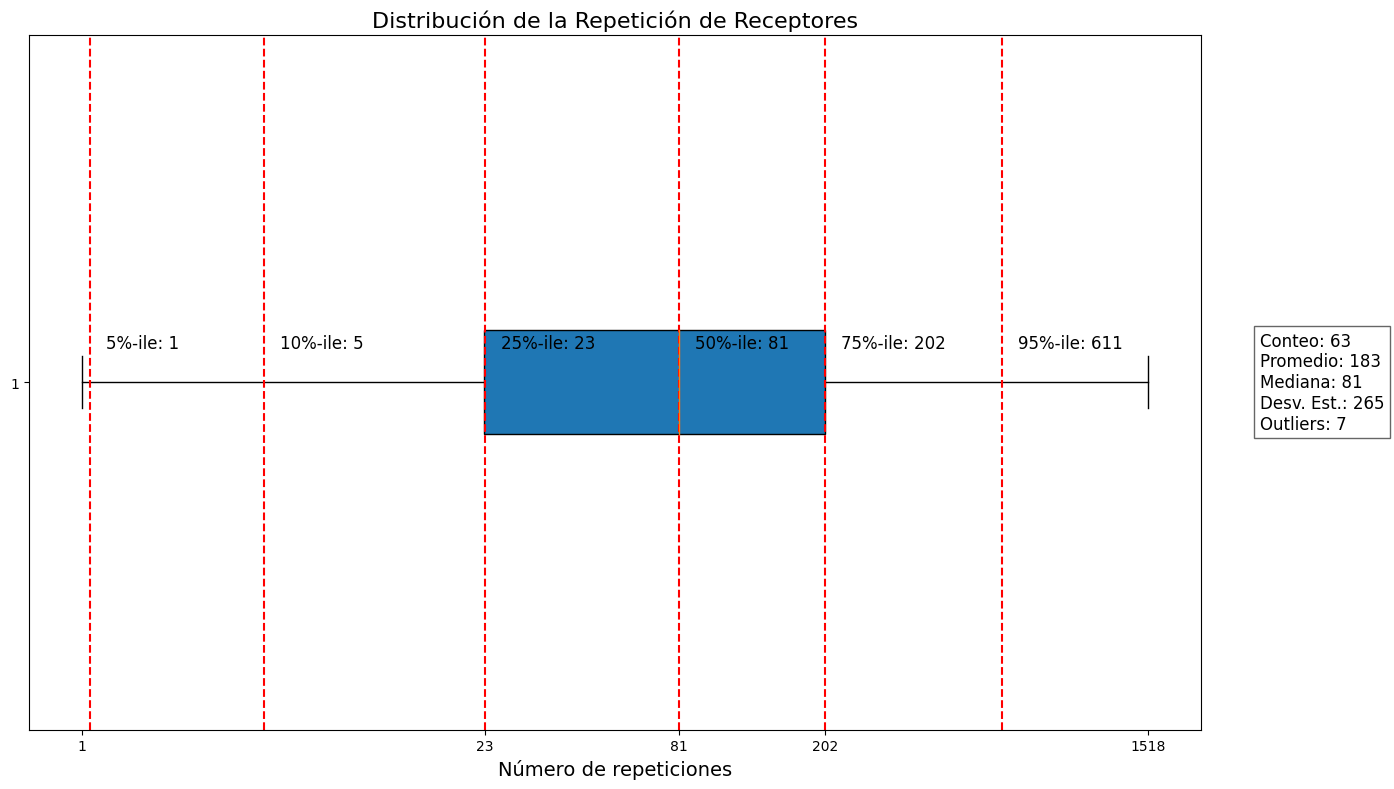

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calcular la frecuencia de los valores en la columna 'receptor_id'
type_counts = df['receptor_id'].value_counts()

# Aplicar la transformación logarítmica
log_type_counts = np.log1p(type_counts)

# Crear la gráfica de caja y bigote (boxplot) en escala logarítmica pero mantener el eje X original
plt.figure(figsize=(14, 8))
plt.boxplot(log_type_counts, vert=False, patch_artist=True)

# Calcular estadísticas descriptivas en la escala logarítmica
stats = type_counts.describe()

# Calcular percentiles en la escala original
percentiles = type_counts.quantile([0.05, 0.10, 0.25, 0.5, 0.75, 0.95])

# Resaltar percentiles en la gráfica y ajustar las anotaciones para evitar superposición
for percentile, value in percentiles.items():
    plt.axvline(np.log1p(value), color='r', linestyle='--')
    plt.text(np.log1p(value) + 0.1, 1.05, f'{int(percentile*100)}%-ile: {int(value)}', 
             ha='left', va='baseline', fontsize=12, color='black')

# Añadir texto con las estadísticas descriptivas en español
plt.text(1.05, 0.5, f'Conteo: {int(stats["count"])}\n'
                    f'Promedio: {int(stats["mean"])}\n'
                    f'Mediana: {int(stats["50%"])}\n'
                    f'Desv. Est.: {int(stats["std"])}\n'
                    f'Outliers: {int(type_counts[(type_counts < percentiles[0.25] - 1.5 * (percentiles[0.75] - percentiles[0.25])) | (type_counts > percentiles[0.75] + 1.5 * (percentiles[0.75] - percentiles[0.25]))].count())}', 
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(facecolor='white', alpha=0.6), va='center')

# Personalizar el gráfico
plt.xlabel('Número de repeticiones', fontsize=14)
plt.title('Distribución de la Repetición de Receptores', fontsize=16)
plt.xticks(np.log1p(type_counts.quantile([0, 0.25, 0.5, 0.75, 1])), 
           labels=[f'{int(value)}' for value in type_counts.quantile([0, 0.25, 0.5, 0.75, 1])])
plt.tight_layout()
plt.show()


In [43]:
# Calcular la frecuencia de los valores en la columna 'receptor_id'
type_counts = df['receptor_id'].value_counts()

# Filtrar el DataFrame para mantener solo los 'receptor_id' que tienen una frecuencia mayor o igual a 5
df = df[df['receptor_id'].isin(type_counts[type_counts >= 25].index)]

# Mostrar el DataFrame filtrado
shape_final = df.shape
print(shape_final)
print(f"Por el momento el Dataset se ha reducido en un {(1-(shape_final[0]/shape_original[0]))*100}%")


(11437, 10)
Por el momento el Dataset se ha reducido en un 4.691666666666672%


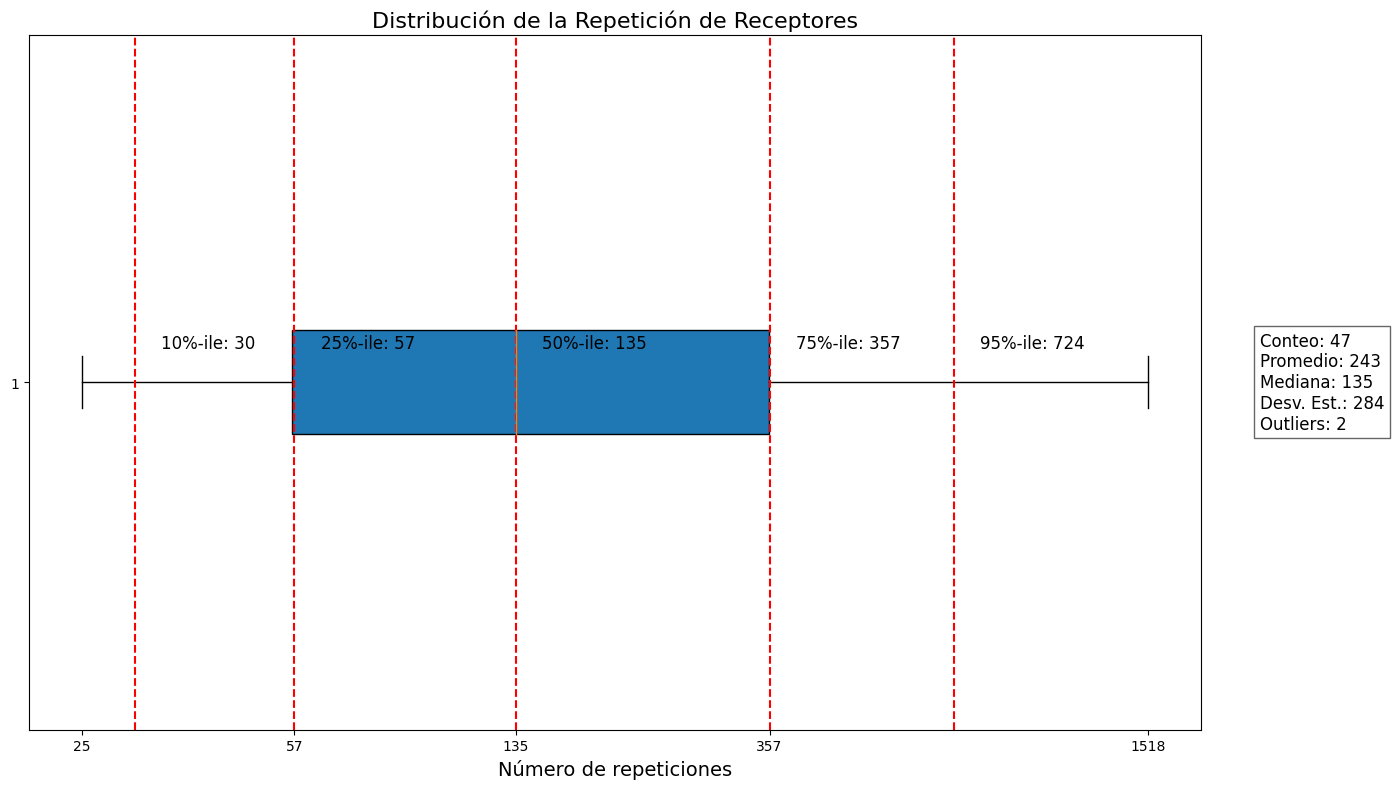

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calcular la frecuencia de los valores en la columna 'receptor_id'
type_counts = df['receptor_id'].value_counts()

# Aplicar la transformación logarítmica
log_type_counts = np.log1p(type_counts)

# Crear la gráfica de caja y bigote (boxplot) en escala logarítmica pero mantener el eje X original
plt.figure(figsize=(14, 8))
plt.boxplot(log_type_counts, vert=False, patch_artist=True)

# Calcular estadísticas descriptivas en la escala logarítmica
stats = type_counts.describe()

# Calcular percentiles en la escala original
percentiles = type_counts.quantile([0.10, 0.25, 0.5, 0.75, 0.95])

# Resaltar percentiles en la gráfica y ajustar las anotaciones para evitar superposición
for percentile, value in percentiles.items():
    plt.axvline(np.log1p(value), color='r', linestyle='--')
    plt.text(np.log1p(value) + 0.1, 1.05, f'{int(percentile*100)}%-ile: {int(value)}', 
             ha='left', va='baseline', fontsize=12, color='black')

# Añadir texto con las estadísticas descriptivas en español
plt.text(1.05, 0.5, f'Conteo: {int(stats["count"])}\n'
                    f'Promedio: {int(stats["mean"])}\n'
                    f'Mediana: {int(stats["50%"])}\n'
                    f'Desv. Est.: {int(stats["std"])}\n'
                    f'Outliers: {int(type_counts[(type_counts < percentiles[0.25] - 1.5 * (percentiles[0.75] - percentiles[0.25])) | (type_counts > percentiles[0.75] + 1.5 * (percentiles[0.75] - percentiles[0.25]))].count())}', 
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(facecolor='white', alpha=0.6), va='center')

# Personalizar el gráfico
plt.xlabel('Número de repeticiones', fontsize=14)
plt.title('Distribución de la Repetición de Receptores', fontsize=16)
plt.xticks(np.log1p(type_counts.quantile([0, 0.25, 0.5, 0.75, 1])), 
           labels=[f'{int(value)}' for value in type_counts.quantile([0, 0.25, 0.5, 0.75, 1])])
plt.tight_layout()
plt.show()


# Análisis de Total

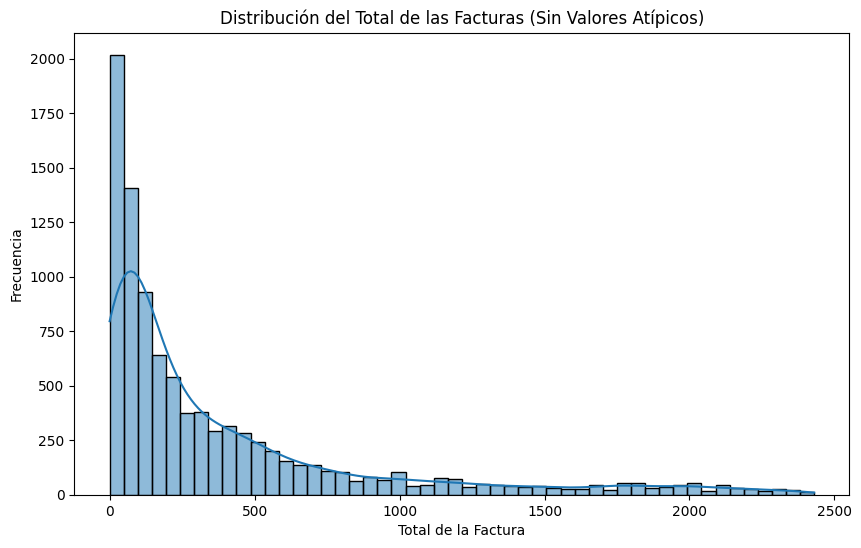

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Verificar si hay problemas con los datos (tipos incorrectos)
df['total'] = pd.to_numeric(df['total'], errors='coerce')

# Eliminar valores nulos que se hayan convertido en NaN
df = df.dropna(subset=['total'])

# Redondear los valores a 2 decimales para simplificar
df['total'] = df['total'].round(2)

# Si aún hay demasiada variación, podrías considerar eliminar outliers extremos
Q1 = df['total'].quantile(0.25)
Q3 = df['total'].quantile(0.75)
IQR = Q3 - Q1

# Eliminar outliers extremos
df_filtered = df[(df['total'] >= (Q1 - 1.5 * IQR)) & (df['total'] <= (Q3 + 1.5 * IQR))]

# Repetir el análisis sin los outliers extremos
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['total'], bins=50, kde=True)
plt.title('Distribución del Total de las Facturas (Sin Valores Atípicos)')
plt.xlabel('Total de la Factura')
plt.ylabel('Frecuencia')
plt.show()



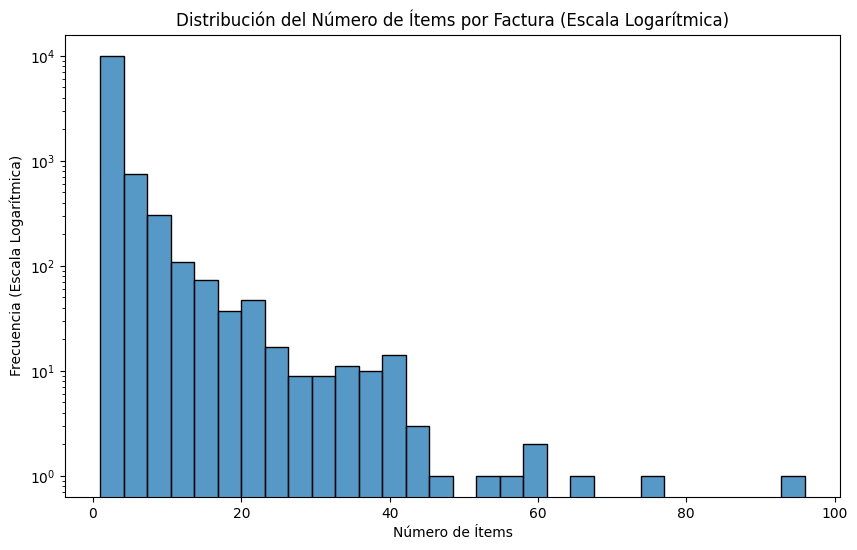

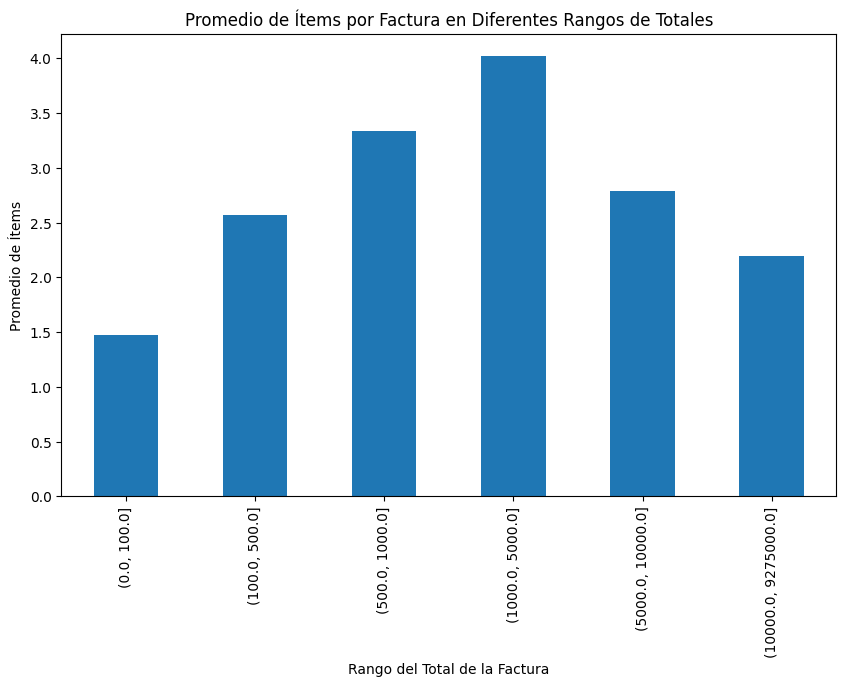

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que df es tu DataFrame original

# Verificar si la columna 'items' es una lista o una cadena de texto y aplicar la conversión solo a cadenas
df['items'] = df['items'].apply(lambda x: x.split(',') if isinstance(x, str) else x)

# Calcular el número de ítems por factura
df['num_items'] = df['items'].apply(len)

# Gráfica 1: Distribución del número de ítems por factura con escala logarítmica en el eje Y
plt.figure(figsize=(10, 6))
sns.histplot(df['num_items'], bins=30, kde=False)
plt.yscale('log')
plt.title('Distribución del Número de Ítems por Factura (Escala Logarítmica)')
plt.xlabel('Número de Ítems')
plt.ylabel('Frecuencia (Escala Logarítmica)')
plt.show()


# Gráfica 4: Promedio de ítems por factura en diferentes rangos de totales (sin cambios)
df['total_range'] = pd.cut(df['total'], bins=[0, 100, 500, 1000, 5000, 10000, df['total'].max()])
avg_items_by_total = df.groupby('total_range')['num_items'].mean()

plt.figure(figsize=(10, 6))
avg_items_by_total.plot(kind='bar')
plt.title('Promedio de Ítems por Factura en Diferentes Rangos de Totales')
plt.xlabel('Rango del Total de la Factura')
plt.ylabel('Promedio de Ítems')
plt.show()


In [47]:
import pandas as pd

# Función recursiva para aplanar diccionarios
def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f'{parent_key}{sep}{k}' if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

# Supongamos que df es tu DataFrame original, con la columna 'items' como lista de ítems

# Crear una lista para almacenar las filas del nuevo dataset
rows = []

# Iterar sobre cada fila en el DataFrame original
for _, row in df.iterrows():
    invoice_data = row.drop('items').to_dict()  # Obtener los datos de la factura excluyendo los ítems
    for item in row['items']:
        item_data = invoice_data.copy()  # Copiar la información de la factura
        
        # Aplanar el diccionario del ítem
        flattened_item = flatten_dict(item, parent_key='item')
        
        # Combinar la información de la factura con la del ítem aplanado
        item_data.update(flattened_item)
        
        rows.append(item_data)  # Añadir la fila al nuevo dataset

# Crear el nuevo DataFrame
df_items = pd.DataFrame(rows)

# Mostrar el resultado
print(df_items.columns)
print(df_items.shape)


Index(['date', 'sender_id', 'establishment_id', 'receptor_id', 'type',
       'currency', 'total', 'year_month', 'sender_establishment', 'num_items',
       'total_range', 'item_line', 'item_quantity', 'item_total', 'item_type',
       'item_measure_unit', 'item_initial_description', 'item_taxes',
       'item_accounting_specifications_out_analytic_classification',
       'item_accounting_specifications_out_accounting_classification',
       'item_accounting_specifications_out_final_description',
       'item_accounting_specifications_out_state',
       'item_accounting_specifications_in_analytic_classification',
       'item_accounting_specifications_in_accounting_classification',
       'item_accounting_specifications_in_final_description',
       'item_accounting_specifications_in_state'],
      dtype='object')
(28858, 26)


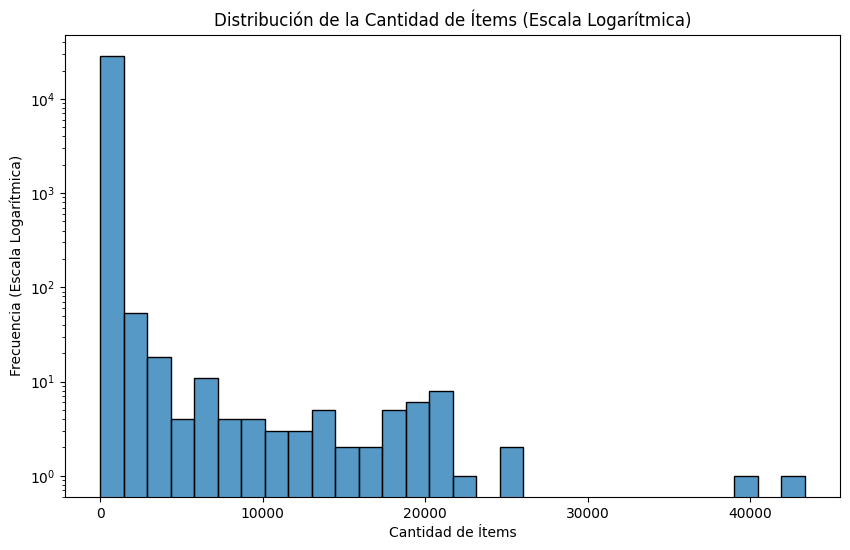

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que df es tu DataFrame y que ya contiene la columna 'item_quantity'

# Asegúrate de que la columna 'item_quantity' está en formato numérico y redondea los valores a enteros
df_items['item_quantity_round'] = pd.to_numeric(df_items['item_quantity'], errors='coerce').round().astype('int')

# Gráfica 1: Distribución de las cantidades de ítems en escala logarítmica (eje Y)
plt.figure(figsize=(10, 6))
sns.histplot(df_items['item_quantity_round'], bins=30, kde=False)
plt.yscale('log')
plt.title('Distribución de la Cantidad de Ítems (Escala Logarítmica)')
plt.xlabel('Cantidad de Ítems')
plt.ylabel('Frecuencia (Escala Logarítmica)')
plt.show()

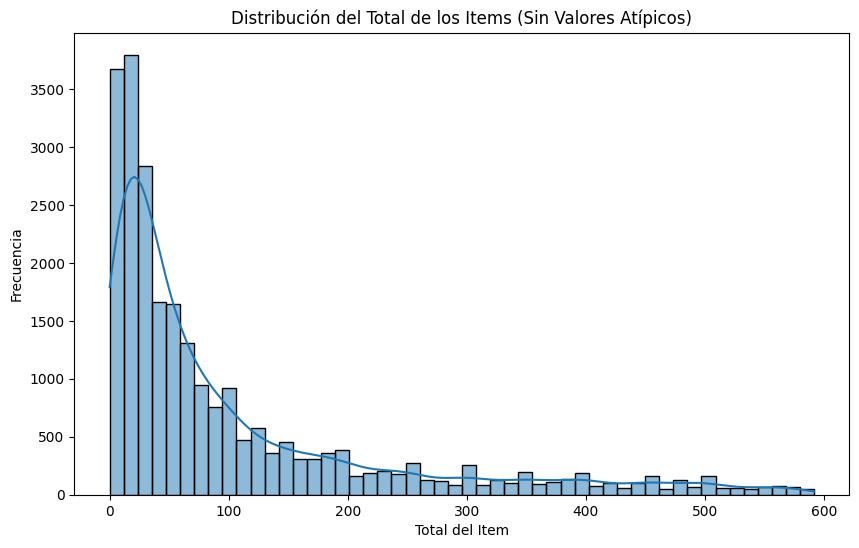

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Verificar si hay problemas con los datos (tipos incorrectos)
df_items['item_total'] = pd.to_numeric(df_items['item_total'], errors='coerce')

# Eliminar valores nulos que se hayan convertido en NaN
df_items = df_items.dropna(subset=['item_total'])

# Redondear los valores a 2 decimales para simplificar
df_items['item_total_round'] = df_items['item_total'].round(2)

# Si aún hay demasiada variación, podrías considerar eliminar outliers extremos
Q1 = df_items['item_total_round'].quantile(0.25)
Q3 = df_items['item_total_round'].quantile(0.75)
IQR = Q3 - Q1

# Eliminar outliers extremos
df_items_filtered = df_items[(df_items['item_total_round'] >= (Q1 - 1.5 * IQR)) & (df_items['item_total_round'] <= (Q3 + 1.5 * IQR))]

# Repetir el análisis sin los outliers extremos
plt.figure(figsize=(10, 6))
sns.histplot(df_items_filtered['item_total_round'], bins=50, kde=True)
plt.title('Distribución del Total de los Items (Sin Valores Atípicos)')
plt.xlabel('Total del Item')
plt.ylabel('Frecuencia')
plt.show()



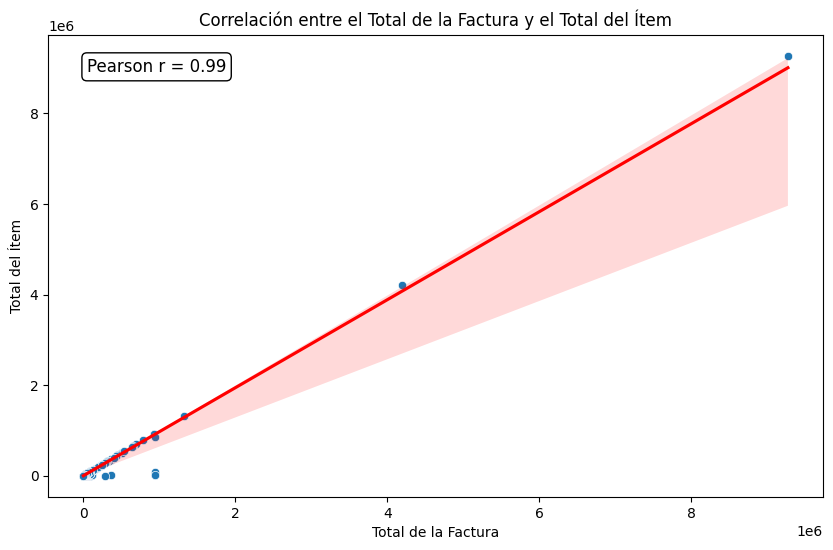

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Supongamos que df_items es tu DataFrame y contiene las columnas 'total' y 'item_total'

# Calcular el coeficiente de correlación de Pearson
corr, _ = pearsonr(df_items['total'], df_items['item_total'])

# Crear una figura y un gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total', y='item_total', data=df_items)

# Añadir una línea de tendencia
sns.regplot(x='total', y='item_total', data=df_items, scatter=False, color='red')

# Mostrar el coeficiente de correlación en la gráfica
plt.text(0.05, 0.95, f'Pearson r = {corr:.2f}', transform=plt.gca().transAxes,
         ha='left', va='top', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

# Configurar el título y las etiquetas
plt.title('Correlación entre el Total de la Factura y el Total del Ítem')
plt.xlabel('Total de la Factura')
plt.ylabel('Total del Ítem')
plt.show()


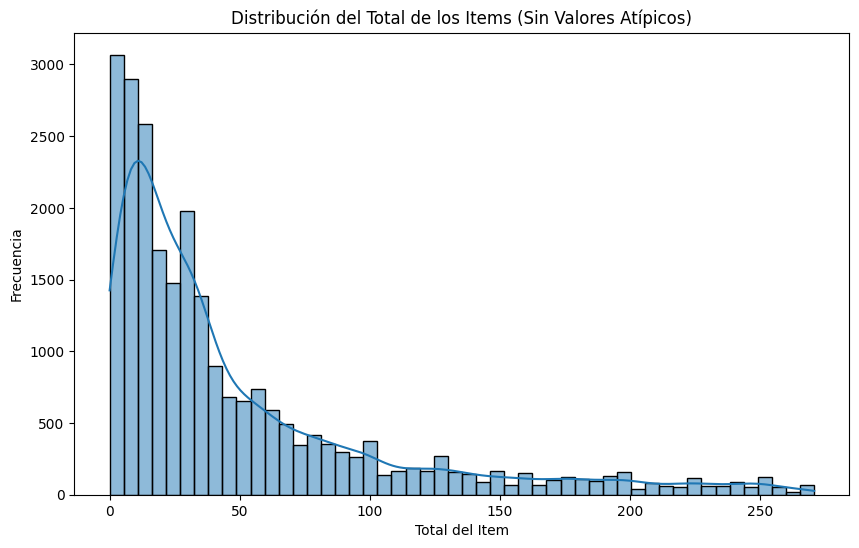

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Redondear los valores a 2 decimales para simplificar
df_items['item_unit_total'] = df_items['item_total'] / df_items['item_quantity']
df_items['item_unit_total'] = df_items['item_unit_total'].round(2)

# Si aún hay demasiada variación, podrías considerar eliminar outliers extremos
Q1 = df_items['item_unit_total'].quantile(0.25)
Q3 = df_items['item_unit_total'].quantile(0.75)
IQR = Q3 - Q1

# Eliminar outliers extremos
df_items_filtered = df_items[(df_items['item_unit_total'] >= (Q1 - 1.5 * IQR)) & (df_items['item_unit_total'] <= (Q3 + 1.5 * IQR))]

# Repetir el análisis sin los outliers extremos
plt.figure(figsize=(10, 6))
sns.histplot(df_items_filtered['item_unit_total'], bins=50, kde=True)
plt.title('Distribución del Total de los Items (Sin Valores Atípicos)')
plt.xlabel('Total del Item')
plt.ylabel('Frecuencia')
plt.show()



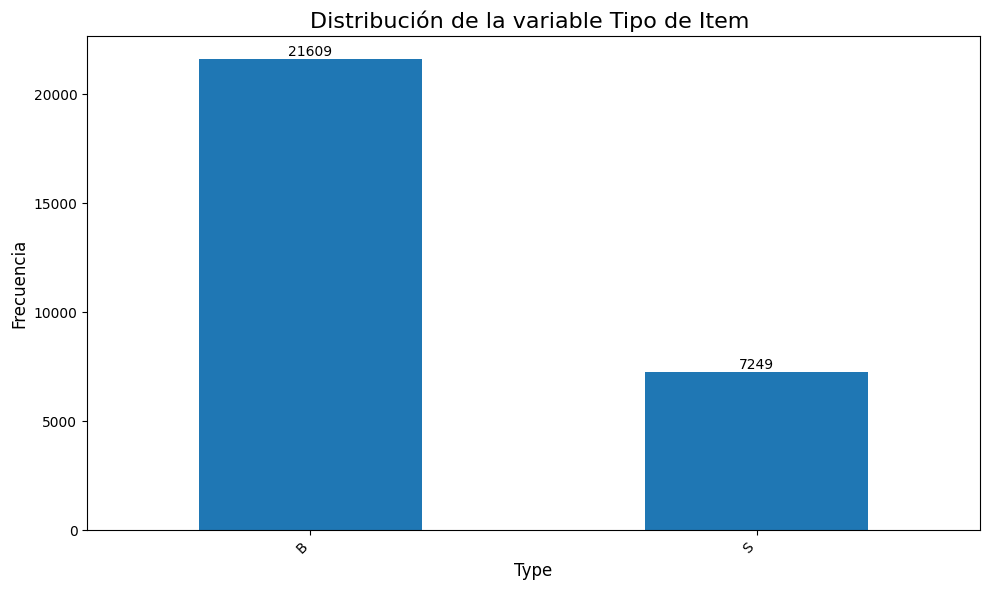

In [52]:
# Calcular la frecuencia de los valores en la columna 'type'
type_counts = df_items['item_type'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar')

# Personalizar el gráfico
plt.xlabel('Type', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de la variable Tipo de Item ', fontsize=16)
plt.xticks(rotation=45, ha='right')

# Añadir etiquetas de valor encima de cada barra
for i, v in enumerate(type_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

In [53]:
import pandas as pd

# Supongamos que df_items es tu DataFrame y contiene la columna 'item_measure_unit'

# Estadísticas descriptivas de la variable 'item_measure_unit'
total_registros = len(df_items['item_measure_unit'])
unidades_unicas = df_items['item_measure_unit'].nunique()
unidad_mas_comun = df_items['item_measure_unit'].mode()[0]
frecuencia_mas_comun = df_items['item_measure_unit'].value_counts().iloc[0]

# Frecuencia de las tres unidades más comunes
top_3_unidades = df_items['item_measure_unit'].value_counts().nlargest(3)

# Mostrar resultados
print(f"Número total de registros: {total_registros}")
print(f"Unidades de medida únicas: {unidades_unicas}")
print(f"Unidad de medida más común: {unidad_mas_comun} ({frecuencia_mas_comun} ocurrencias)")
print("\nFrecuencia de las tres unidades más comunes:")
print(top_3_unidades)


Número total de registros: 28858
Unidades de medida únicas: 143
Unidad de medida más común: UND (6265 ocurrencias)

Frecuencia de las tres unidades más comunes:
UND    6265
1      6068
UNI    5142
Name: item_measure_unit, dtype: int64


In [54]:
# Convertir la variable en string
df_items['item_accounting_specifications_out_accounting_classification'] = df_items['item_accounting_specifications_out_accounting_classification'].astype(str)
df_items['item_accounting_specifications_out_accounting_classification'].describe()

count     28858
unique      655
top       40894
freq       1449
Name: item_accounting_specifications_out_accounting_classification, dtype: object

Estadísticas descriptivas de la frecuencia de las cuentas contables (sin outliers):
count    573.000000
mean      13.200698
std       14.817534
min        1.000000
25%        3.000000
50%        7.000000
75%       18.000000
max       66.000000
Name: item_accounting_specifications_out_accounting_classification, dtype: float64


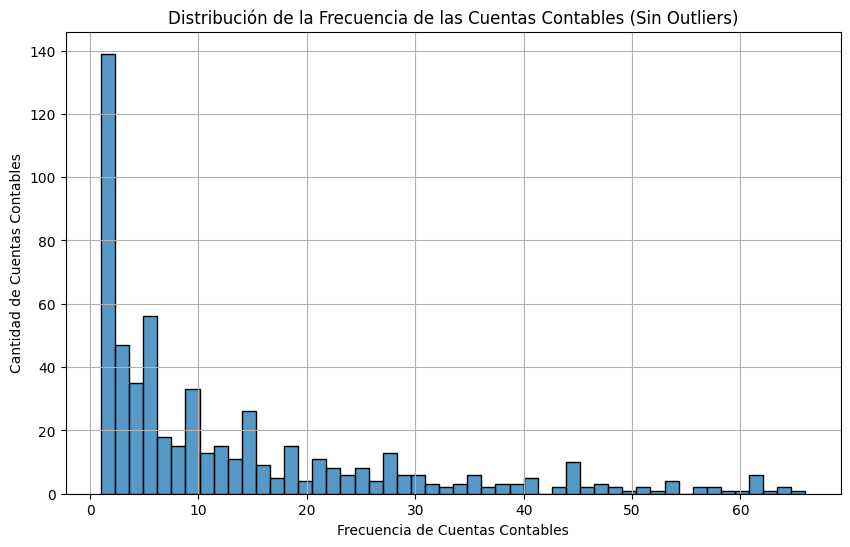

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Conteo de la frecuencia de cada cuenta contable
cuenta_contable_frecuencia = df_items['item_accounting_specifications_out_accounting_classification'].value_counts()

# 2. Eliminación de outliers extremos utilizando el rango intercuartílico (IQR)
Q1 = cuenta_contable_frecuencia.quantile(0.25)
Q3 = cuenta_contable_frecuencia.quantile(0.75)
IQR = Q3 - Q1

# Filtrar los datos para eliminar outliers extremos
cuenta_contable_frecuencia_filtrada = cuenta_contable_frecuencia[(cuenta_contable_frecuencia >= (Q1 - 1.5 * IQR)) & 
                                                                 (cuenta_contable_frecuencia <= (Q3 + 1.5 * IQR))]

# 3. Estadísticas descriptivas generales sin los outliers
stats_descriptivas_filtradas = cuenta_contable_frecuencia_filtrada.describe()
print("Estadísticas descriptivas de la frecuencia de las cuentas contables (sin outliers):")
print(stats_descriptivas_filtradas)

# 4. Visualización mediante un histograma
plt.figure(figsize=(10, 6))
sns.histplot(cuenta_contable_frecuencia_filtrada, bins=50, kde=False)
plt.title('Distribución de la Frecuencia de las Cuentas Contables (Sin Outliers)')
plt.xlabel('Frecuencia de Cuentas Contables')
plt.ylabel('Cantidad de Cuentas Contables')
plt.grid(True)
plt.show()


In [56]:
import pandas as pd

# Supongamos que tu DataFrame se llama df y contiene la columna 'item_accounting_specifications_out_accounting_classification'

# 1. Conteo de la frecuencia de cada cuenta contable
cuenta_contable_frecuencia = df_items['item_accounting_specifications_out_accounting_classification'].value_counts()

# 2. Filtrar las cuentas contables con frecuencia mayor a 10
cuentas_frecuencia_mayor_10 = cuenta_contable_frecuencia[cuenta_contable_frecuencia > 5].index

# 3. Filtrar el DataFrame original para mantener solo estas cuentas contables
df_items_filtrado = df_items[df_items['item_accounting_specifications_out_accounting_classification'].isin(cuentas_frecuencia_mayor_10)]

# 4. Calcular el porcentaje del dataset que se elimina
total_original = len(df_items)
total_filtrado = len(df_items_filtrado)
porcentaje_eliminado = ((total_original - total_filtrado) / total_original) * 100

# Mostrar los resultados
print(f"Total original de registros: {total_original}")
print(f"Total de registros después de filtrar: {total_filtrado}")
print(f"Porcentaje del dataset eliminado: {porcentaje_eliminado:.2f}%")


df_items_filtrado['item_accounting_specifications_out_accounting_classification'].describe()

Total original de registros: 28858
Total de registros después de filtrar: 28243
Porcentaje del dataset eliminado: 2.13%


count     28243
unique      405
top       40894
freq       1449
Name: item_accounting_specifications_out_accounting_classification, dtype: object

C:\Users\juanc\AppData\Local\Temp\ipykernel_40260\683920008.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_items_filtrado['item_accounting_specifications_out_accounting_classification'] = df_items_filtrado['item_accounting_specifications_out_accounting_classification'].astype(str)


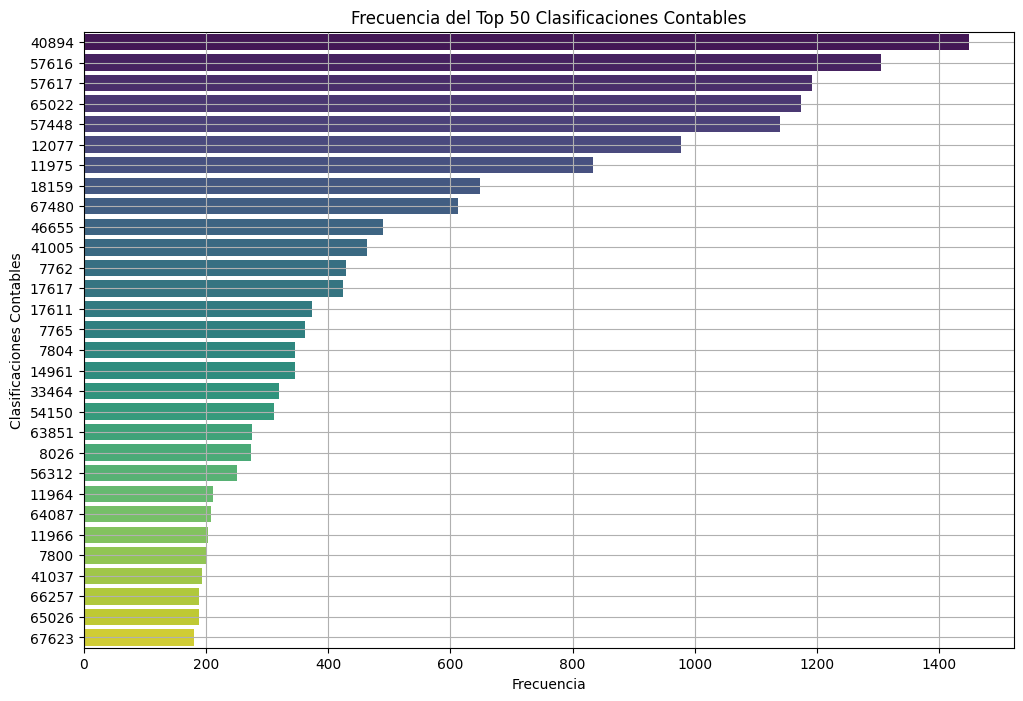

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que tu DataFrame se llama df y contiene la columna 'item_accounting_specifications_out_accounting_classification'

# Convertir la variable en string (si no lo has hecho ya)
df_items_filtrado['item_accounting_specifications_out_accounting_classification'] = df_items_filtrado['item_accounting_specifications_out_accounting_classification'].astype(str)

# 1. Conteo de la frecuencia de cada cuenta contable
cuenta_contable_frecuencia = df_items_filtrado['item_accounting_specifications_out_accounting_classification'].value_counts()

# 2. Filtrar el top 50 clasificaciones contables
top_50_cuentas = cuenta_contable_frecuencia.head(30)

# 3. Visualización del top 50 clasificaciones contables
plt.figure(figsize=(12, 8))
sns.barplot(x=top_50_cuentas.values, y=top_50_cuentas.index, palette="viridis")
plt.title('Frecuencia del Top 50 Clasificaciones Contables')
plt.xlabel('Frecuencia')
plt.ylabel('Clasificaciones Contables')
plt.grid(True)
plt.show()


C:\Users\juanc\AppData\Local\Temp\ipykernel_40260\4291997064.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_items_filtrado['item_accounting_specifications_out_accounting_classification'] = df_items_filtrado['item_accounting_specifications_out_accounting_classification'].astype(str)
C:\Users\juanc\AppData\Local\Temp\ipykernel_40260\4291997064.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_items_filtrado['receptor_id'] = df_items_filtrado['receptor_id'].astype(str)


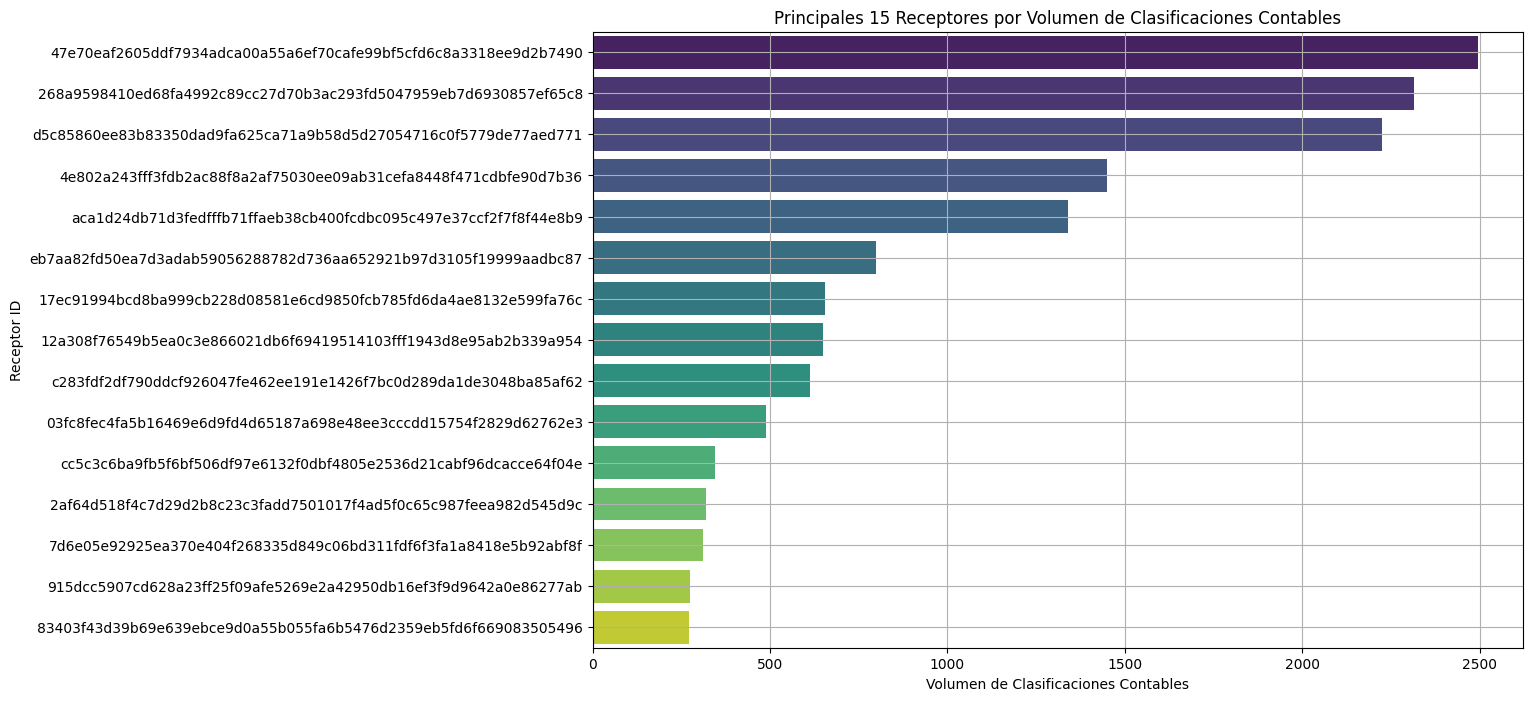

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que tu DataFrame se llama df_items_filtrado y contiene las columnas 'item_accounting_specifications_out_accounting_classification' y 'receptor_id'

# Convertir las variables en string (si no lo has hecho ya)
df_items_filtrado['item_accounting_specifications_out_accounting_classification'] = df_items_filtrado['item_accounting_specifications_out_accounting_classification'].astype(str)
df_items_filtrado['receptor_id'] = df_items_filtrado['receptor_id'].astype(str)

# 1. Filtrar el top 30 clasificaciones contables
top_30_clasificaciones = df_items_filtrado['item_accounting_specifications_out_accounting_classification'].value_counts().head(30).index

# 2. Filtrar el DataFrame para incluir solo las clasificaciones del top 30
df_items_filtrado_top_30 = df_items_filtrado[df_items_filtrado['item_accounting_specifications_out_accounting_classification'].isin(top_30_clasificaciones)]

# 3. Agrupar por receptor y clasificaciones, y calcular el volumen total
volumen_por_receptor = df_items_filtrado_top_30.groupby('receptor_id')['item_accounting_specifications_out_accounting_classification'].count().reset_index()
volumen_por_receptor = volumen_por_receptor.sort_values(by='item_accounting_specifications_out_accounting_classification', ascending=False)

# 4. Visualización de los principales receptores por volumen de clasificaciones
plt.figure(figsize=(12, 8))
sns.barplot(x=volumen_por_receptor['item_accounting_specifications_out_accounting_classification'].head(15), 
            y=volumen_por_receptor['receptor_id'].head(15), palette="viridis")
plt.title('Principales 15 Receptores por Volumen de Clasificaciones Contables')
plt.xlabel('Volumen de Clasificaciones Contables')
plt.ylabel('Receptor ID')
plt.grid(True)
plt.show()


C:\Users\juanc\AppData\Local\Temp\ipykernel_40260\3466912814.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_items_filtrado['item_accounting_specifications_out_accounting_classification'] = df_items_filtrado['item_accounting_specifications_out_accounting_classification'].astype(str)
C:\Users\juanc\AppData\Local\Temp\ipykernel_40260\3466912814.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_items_filtrado['receptor_id'] = df_items_filtrado['receptor_id'].astype(str)


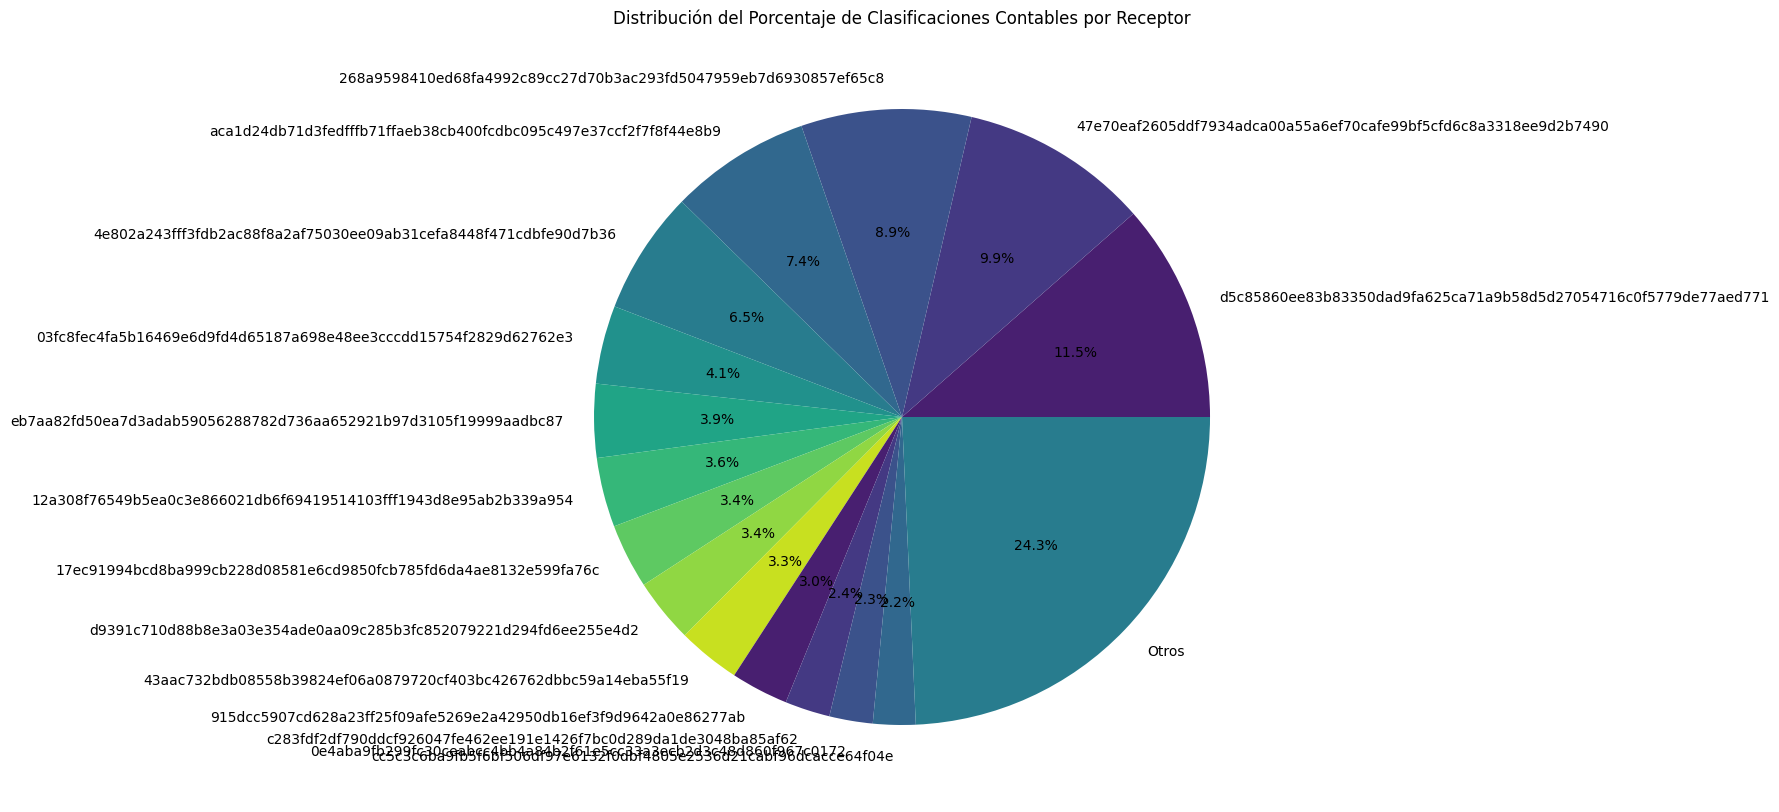

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que tu DataFrame se llama df_items_filtrado y contiene las columnas 'item_accounting_specifications_out_accounting_classification' y 'receptor_id'

# Convertir las variables en string (si no lo has hecho ya)
df_items_filtrado['item_accounting_specifications_out_accounting_classification'] = df_items_filtrado['item_accounting_specifications_out_accounting_classification'].astype(str)
df_items_filtrado['receptor_id'] = df_items_filtrado['receptor_id'].astype(str)

# 1. Agrupar por receptor y clasificaciones, y calcular el volumen total
volumen_por_receptor = df_items_filtrado.groupby('receptor_id')['item_accounting_specifications_out_accounting_classification'].count().reset_index()
volumen_por_receptor = volumen_por_receptor.sort_values(by='item_accounting_specifications_out_accounting_classification', ascending=False)

# 2. Calcular el porcentaje del total por receptor
volumen_total = volumen_por_receptor['item_accounting_specifications_out_accounting_classification'].sum()
volumen_por_receptor['percentage'] = (volumen_por_receptor['item_accounting_specifications_out_accounting_classification'] / volumen_total) * 100

# 3. Preparar los datos para el gráfico de pastel con el segmento "Otros"
top_15 = volumen_por_receptor.head(15)
otros = pd.DataFrame({
    'receptor_id': ['Otros'],
    'item_accounting_specifications_out_accounting_classification': [volumen_por_receptor['item_accounting_specifications_out_accounting_classification'][15:].sum()],
    'percentage': [volumen_por_receptor['percentage'][15:].sum()]
})

# Combinar los top 15 con el segmento "Otros"
volumen_pie_chart = pd.concat([top_15, otros])

# 4. Visualización del porcentaje de contribución de los principales receptores (gráfico de pastel)
plt.figure(figsize=(10, 10))
plt.pie(volumen_pie_chart['percentage'], labels=volumen_pie_chart['receptor_id'], autopct='%1.1f%%', colors=sns.color_palette("viridis", 11))
plt.title('Distribución del Porcentaje de Clasificaciones Contables por Receptor')
plt.show()



In [60]:
df_items_filtered.columns

Index(['date', 'sender_id', 'establishment_id', 'receptor_id', 'type',
       'currency', 'total', 'year_month', 'sender_establishment', 'num_items',
       'total_range', 'item_line', 'item_quantity', 'item_total', 'item_type',
       'item_measure_unit', 'item_initial_description', 'item_taxes',
       'item_accounting_specifications_out_analytic_classification',
       'item_accounting_specifications_out_accounting_classification',
       'item_accounting_specifications_out_final_description',
       'item_accounting_specifications_out_state',
       'item_accounting_specifications_in_analytic_classification',
       'item_accounting_specifications_in_accounting_classification',
       'item_accounting_specifications_in_final_description',
       'item_accounting_specifications_in_state', 'item_quantity_round',
       'item_total_round', 'item_unit_total'],
      dtype='object')

In [61]:
df_items_filtered = df_items_filtered[['date', 'sender_id', 'establishment_id', 'receptor_id', 'type', 'item_unit_total', 'item_initial_description', 'item_accounting_specifications_out_final_description', 'item_accounting_specifications_out_accounting_classification']]
# Eliminar las columnas no necesarias para modelos de ML
df_ml_models = df_items_filtered.drop(columns=['date', 'item_initial_description', 'item_accounting_specifications_out_final_description'])

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Separar las características y la variable esperada
X = df_ml_models.drop(columns=['item_accounting_specifications_out_accounting_classification'])
y = df_ml_models['item_accounting_specifications_out_accounting_classification']

# Convertir las columnas específicas a variables dummy
X = pd.get_dummies(X, columns=['sender_id', 'establishment_id', 'receptor_id', 'type'])

# Codificación de la variable objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Lista de modelos para probar
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

# Lista para almacenar los resultados detallados
results = []

# Evaluar cada modelo
for name, model in models.items():
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Calcular la exactitud
    accuracy = accuracy_score(y_test, y_pred)
    
    # Reporte de clasificación detallado por clase
    report = classification_report(y_test, y_pred, output_dict=True)

    # Almacenar los resultados detallados por clase
    for class_label, metrics in report.items():
        if class_label not in ['accuracy', 'macro avg', 'weighted avg']:
            results.append({
                'Modelo': name,
                'Clase': class_label,
                'Exactitud': accuracy,
                'Precisión': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Soporte': metrics['support']
            })

# Convertir los resultados a un DataFrame de pandas
results_df = pd.DataFrame(results)

# Guardar los resultados en un archivo Excel
results_df.to_excel('resultados_detallados_modelos.xlsx', index=False)

print("Los resultados detallados se han guardado en 'resultados_detallados_modelos.xlsx'")


C:\Users\juanc\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\juanc\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\juanc\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall

Los resultados detallados se han guardado en 'resultados_detallados_modelos.xlsx'
